In [1]:
import pandas as pd
import numpy as np
import os
import re
import time
import datetime
import gc
import string
import re
import seaborn as sns 
import matplotlib.pyplot as plt 
import math

from decimal import Decimal, getcontext

# --------------------------------------------

output_dir = r"E:\Cristian\1. Molecular Dinamics\2. Python Projects\3. Jupiter Code\6. NH Friction Index\2. Long Range\3. NH_0.02"

# Construir las rutas de los archivos basadas en output_dir
particle_data_file = os.path.join(output_dir, "Particle_Data.csv")
system_data_file = os.path.join(output_dir, "System_Data.csv")

Partic_DF = pd.read_csv(particle_data_file)
System_DF = pd.read_csv(system_data_file)

# --------------------------------------------

simulation_data_file = os.path.join(output_dir, "Simulation_Values.csv")

Simulation_Values = pd.read_csv(simulation_data_file)

Q = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'Q_p', 'Valor'].iloc[0])
m = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'm', 'Valor'].iloc[0])
N = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'N', 'Valor'].iloc[0])
kB = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'kB', 'Valor'].iloc[0])
Temp_Target = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'Temp_Target', 'Valor'].iloc[0])
e0 = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'e0', 'Valor'].iloc[0])


r_2 = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'r_2', 'Valor'].iloc[0])
r_1 = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'r_1', 'Valor'].iloc[0])
r_G = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'r_G', 'Valor'].iloc[0])

Lim_Inf = 50000
Lim_Sup = 2000000


In [2]:
def obtener_columnas_object(dataframe):
    columnas_object = []
    tipos_datos = dataframe.dtypes
    for columna, tipo in tipos_datos.items():
        if tipo == 'object':
            columnas_object.append(columna)
    return columnas_object

# -------- Conversión de data types y alistamiento de dataframes originales --------

columns_to_convert = obtener_columnas_object(System_DF)
# print(columns_to_convert)
System_DF[columns_to_convert] = System_DF[columns_to_convert].replace(',', '.', regex=True)
System_DF[columns_to_convert] = System_DF[columns_to_convert].astype(float)
# print(System_DF.dtypes)

columns_to_convert = obtener_columnas_object(Partic_DF)
# print(columns_to_convert)
Partic_DF[columns_to_convert] = Partic_DF[columns_to_convert].replace(',', '.', regex=True)
Partic_DF[columns_to_convert] = Partic_DF[columns_to_convert].astype(float)
# print(Partic_DF.dtypes)


In [3]:

Partic_DF = Partic_DF[(Partic_DF['Step'] >= Lim_Inf) & (Partic_DF['Step'] <= Lim_Sup)]
System_DF = System_DF[(System_DF['Step'] >= Lim_Inf) & (System_DF['Step'] <= Lim_Sup)]


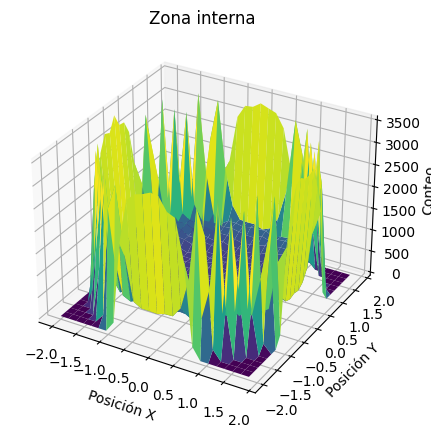

<Figure size 500x500 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Obtener las posiciones X, Y del DataFrame
x = Partic_DF["X_Pos"]
y = Partic_DF["Y_Pos"]

# Calcular las distancias desde el origen
distancias = np.sqrt(x**2 + y**2)

# Crear máscaras para seleccionar los puntos correspondientes a cada zona
mask_interna = distancias <= r_1
mask_externa = np.logical_and(distancias > r_G, distancias <= r_2)

# Obtener las coordenadas correspondientes a cada zona
x_interna = x[mask_interna]
y_interna = y[mask_interna]
x_externa = x[mask_externa]
y_externa = y[mask_externa]

# Crear una malla para la zona interna
bins_interna = 25  # Ajusta el número de bins según tus necesidades
counts_interna, x_edges_interna, y_edges_interna = np.histogram2d(x_interna, y_interna, bins=bins_interna)
X_interna, Y_interna = np.meshgrid(x_edges_interna[:-1], y_edges_interna[:-1])
Z_interna = counts_interna.T

# Crear una malla para la zona externa
bins_externa = 25  # Ajusta el número de bins según tus necesidades
counts_externa, x_edges_externa, y_edges_externa = np.histogram2d(x_externa, y_externa, bins=bins_externa)
X_externa, Y_externa = np.meshgrid(x_edges_externa[:-1], y_edges_externa[:-1])
Z_externa = counts_externa.T

# Crear la figura y los gráficos 3D
fig1 = plt.figure(figsize=(5, 5))
fig2 = plt.figure(figsize=(5, 5))

# Graficar la zona interna
ax_interna = fig1.add_subplot(111, projection='3d')
ax_interna.plot_surface(X_interna, Y_interna, Z_interna, cmap='viridis')
ax_interna.set_title('Zona interna')
ax_interna.set_xlabel('Posición X')
ax_interna.set_ylabel('Posición Y')
ax_interna.set_zlabel('Conteo')

# Guardar la figura 1
fig1.savefig(os.path.join(output_dir, "3D_Charge_Dist1.png"))

# Mostrar el gráfico 3D de la zona interna
plt.show()

# Graficar la zona externa
ax_externa = fig2.add_subplot(111, projection='3d')
ax_externa.plot_surface(X_externa, Y_externa, Z_externa, cmap='viridis')
ax_externa.set_title('Zona externa')
ax_externa.set_xlabel('Posición X')
ax_externa.set_ylabel('Posición Y')
ax_externa.set_zlabel('Conteo')

# Guardar la figura 2
fig2.savefig(os.path.join(output_dir, "3D_Charge_Dist2.png"))


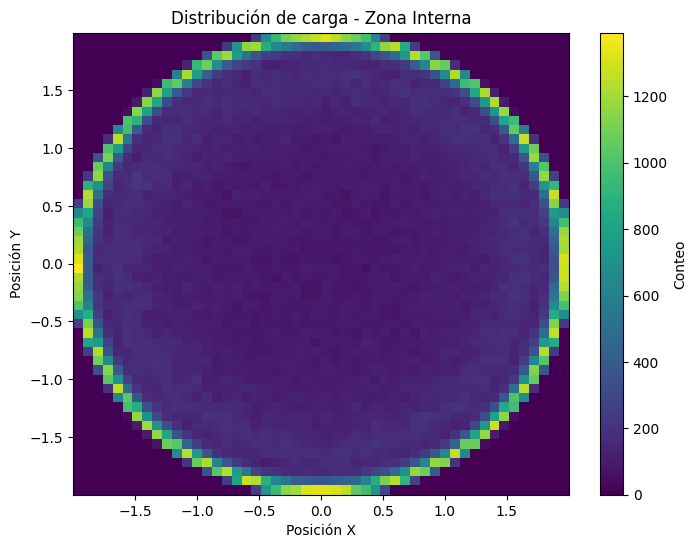

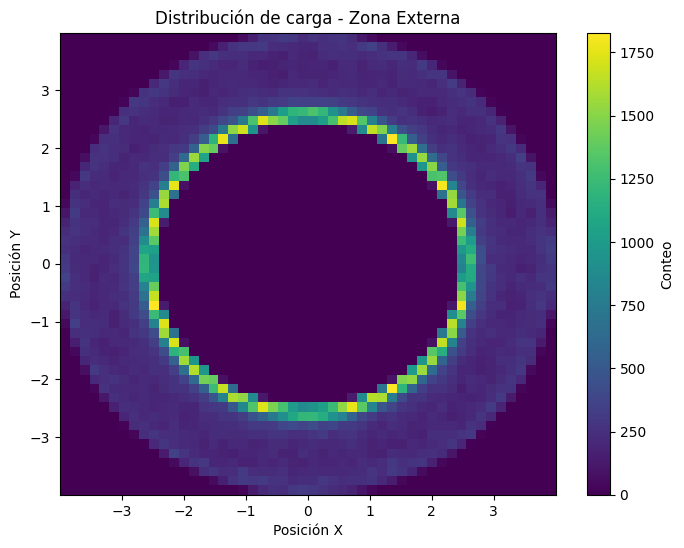

In [5]:
def graficar_zona(Partic_DF, r_1, r_2, bins, zona, name):
    # Obtener las posiciones X, Y del DataFrame
    x = Partic_DF["X_Pos"]
    y = Partic_DF["Y_Pos"]

    # Calcular las distancias desde el origen
    distancias = np.sqrt(x**2 + y**2)

    # Crear máscaras para seleccionar los puntos correspondientes a cada zona
    mask_interna = distancias <= r_1
    mask_externa = np.logical_and(distancias > r_G, distancias <= r_2)

    # Obtener las coordenadas correspondientes a la zona seleccionada
    if zona == "interna":
        x_zona = x[mask_interna]
        y_zona = y[mask_interna]
    elif zona == "externa":
        x_zona = x[mask_externa]
        y_zona = y[mask_externa]
    else:
        raise ValueError("La zona debe ser 'interna' o 'externa'.")

    # Crear el gráfico de la zona seleccionada
    plt.figure(figsize=(8, 6))
    plt.hist2d(x_zona, y_zona, bins=bins, cmap='viridis')
    plt.colorbar(label='Conteo')
    plt.title(f"Distribución de carga - Zona {zona.capitalize()}")
    plt.xlabel('Posición X')
    plt.ylabel('Posición Y')

    plt.savefig(os.path.join(output_dir, name))
    
    # Mostrar el gráfico
    plt.show()
    
graficar_zona(Partic_DF, r_1, r_2, 50, "interna", "2D_Int_Charge_Dist.png")
graficar_zona(Partic_DF, r_1, r_2, 50, "externa", "2D_Ext_Charge_Dist.png")


In [6]:
from numpy import linalg as LA

# Calcula la suma de 'Ke_Energy' para cada valor único en 'Step'
grouped_sum = Partic_DF.groupby('Step')['Ke_Energy'].sum()

# Asigna la suma correspondiente a cada fila en 'Calo_Cap'
Partic_DF['Ke_Total'] = Partic_DF['Step'].map(grouped_sum)

Partic_DF['Ke_Mean'] = Partic_DF['Vel_M']**2
Partic_DF['Ke_Mean'] = Partic_DF.groupby('Step')['Ke_Mean'].transform('mean')
Partic_DF['Ke_Mean'] = Partic_DF['Ke_Mean']*m*0.5


def magnitude(vector) : 
    return LA.norm(vector)

def q(n) : 
    if n < N/2: 
      return Q # n will start at zero
    else : 
      return -Q

def Potencial_Energy(df):
    N = len(df)  # Obtener el número de filas en el DataFrame
    rVector = df[['X_Pos', 'Y_Pos']].values  # Obtener los valores de las columnas 'x' y 'y' como una matriz numpy
    Conts = 1 / (4 * np.pi * e0)
    Sum_m = 0
    
    for m in range(0, N):
        Qm = q(m)
        Sum_n = 0
        
        for n in range(0, N):
            if m != n:
                Qn = q(n)
                Dist = magnitude(rVector[n] - rVector[m])
                Sum_n += Qn * Conts * (1 / Dist)
      
        Sum_m += Qm * Sum_n
    
    return Sum_m

grouped = Partic_DF.groupby('Step')

for step, group in grouped:
    Pot_Energy = Potencial_Energy(group)
    Partic_DF.loc[group.index, 'Pot_Energy'] = Pot_Energy
    
    print((step/System_DF['Step'].max())*100)


# Realizar la fusión (merge) de los DataFrames basándote en la columna 'Step'
Partic_DF = pd.merge(Partic_DF, System_DF[['Step', 'Temp_Tar']], on='Step', how='left')
Partic_DF = pd.merge(Partic_DF, System_DF[['Step', 'Temp_Act']], on='Step', how='left')

Partic_DF['Total_E'] = Partic_DF['Ke_Total'] + Partic_DF['Pot_Energy']
Partic_DF['Total_EE'] = Partic_DF['Total_E']**2




5.0
5.01
5.0200000000000005
5.029999999999999
5.04
5.050000000000001
5.06
5.07
5.08
5.09
5.1
5.11
5.12
5.13
5.140000000000001
5.1499999999999995
5.16
5.17
5.18
5.19
5.2
5.21
5.220000000000001
5.2299999999999995
5.24
5.25
5.26
5.27
5.28
5.29
5.3
5.3100000000000005
5.319999999999999
5.33
5.34
5.35
5.36
5.37
5.38
5.390000000000001
5.4
5.41
5.42
5.43
5.4399999999999995
5.45
5.46
5.47
5.48
5.489999999999999
5.5
5.510000000000001
5.52
5.53
5.54
5.55
5.56
5.57
5.58
5.59
5.6000000000000005
5.609999999999999
5.62
5.63
5.64
5.65
5.66
5.67
5.680000000000001
5.6899999999999995
5.7
5.71
5.72
5.7299999999999995
5.74
5.75
5.76
5.7700000000000005
5.779999999999999
5.79
5.800000000000001
5.81
5.82
5.83
5.84
5.8500000000000005
5.86
5.87
5.88
5.89
5.8999999999999995
5.91
5.92
5.93
5.94
5.949999999999999
5.96
5.970000000000001
5.9799999999999995
5.99
6.0
6.01
6.02
6.03
6.04
6.05
6.0600000000000005
6.069999999999999
6.08
6.09
6.1
6.11
6.12
6.13
6.140000000000001
6.15
6.16
6.17
6.18
6.1899999999999995
6.2
6

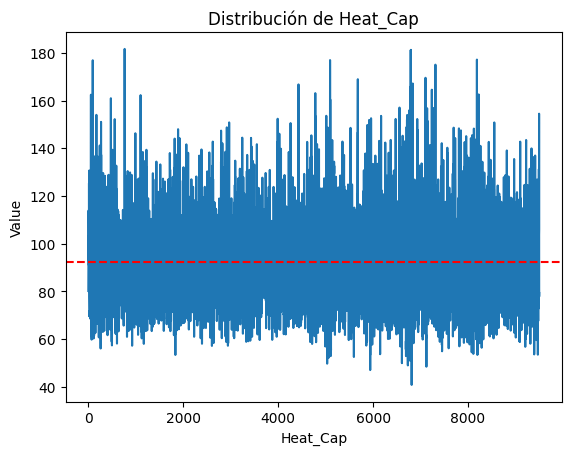

92.38150431235793


In [7]:
Partic_DF['Heat_Cap'] =  (1/(kB*(Partic_DF['Temp_Act']**2))) * (Partic_DF['Total_EE'].mean() - ((Partic_DF['Total_E'].mean())**2))

def Plot_Dist (df,colum,line_value,name):

    # Group the DataFrame by the 'Steps' column
    grouped_df = df.groupby('Step')

    # Extract the unique values of the 'Value' column
    unique_values = grouped_df[colum].unique()
    
    plt.close("all") #this is the line to be added
    num_steps = len(unique_values)
    plt.plot(range(num_steps), unique_values)
    plt.xlabel('Heat_Cap')
    plt.ylabel('Value')
    plt.title('Distribución de Heat_Cap')
    # plt.savefig(os.path.join(output_dir, "Vy_Mean_Distribution.png"))
    plt.axhline(y=line_value, color='red', linestyle='--')
    plt.savefig(os.path.join(output_dir, name))
    plt.show()
    
Plot_Dist(Partic_DF,'Heat_Cap',Partic_DF['Heat_Cap'].mean(),"Heat_Cap_Dist.png")
print(Partic_DF['Heat_Cap'].mean())

475046
2.000739053851413


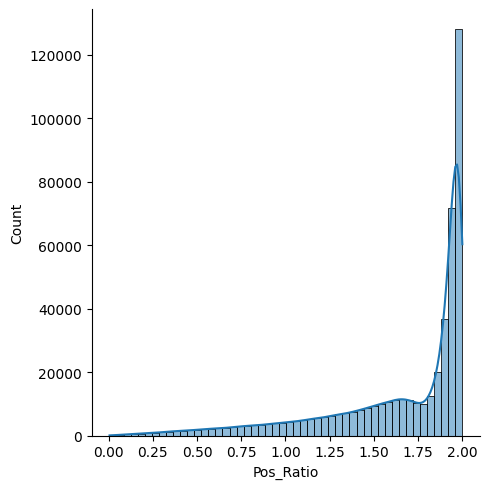

In [8]:
Partic_DF = Partic_DF[Partic_DF['Particle'] <= N/2]

Partic_DF["Pos_Ratio"] = np.sqrt((Partic_DF['X_Pos']**2) + (Partic_DF['Y_Pos']**2))



Muestras = 50  # Número de muestras

# Calcular el tamaño de cada intervalo
interval_size = r_1 / Muestras

# Crear una lista de diccionarios para almacenar los resultados
resultados = []

# Calcular el rango de valores para cada intervalo y almacenarlos en la lista de resultados
for i in range(Muestras):
    inicio = i * interval_size
    fin = (i + 1) * interval_size
    resultados.append({'Intervalo': f'({inicio}, {fin})', 'Inicio': inicio, 'Fin': fin})

# Crear el DataFrame a partir de la lista de resultados
Density_Info = pd.DataFrame(resultados)



# Crear una lista para almacenar los contadores de densidad de carga
densidad_carga = [0] * Muestras

# Iterar sobre cada valor en la columna Pos_Ratio de Particle_DF
for valor in Partic_DF['Pos_Ratio']:
    # Verificar en qué intervalo se encuentra el valor
    for i in range(Muestras):
        inicio = i * interval_size
        fin = (i + 1) * interval_size
        if inicio <= valor < fin:
            # Incrementar el contador correspondiente al intervalo
            densidad_carga[i] += 1
            break  # Romper el bucle una vez que se ha encontrado el intervalo

# Crear una columna "Densidad_Carga" en el DataFrame df_resultados
Density_Info['Count'] = densidad_carga

print(sum(Density_Info['Count']))

# sns.displot(Density_Info, x="Densidad_Carga",bins=Muestras, kde=True)
sns.displot(Partic_DF, x="Pos_Ratio",bins=Muestras, kde=True)
print(Partic_DF["Pos_Ratio"].max())
plt.savefig(os.path.join(output_dir, "Ratial_Dist.png"))

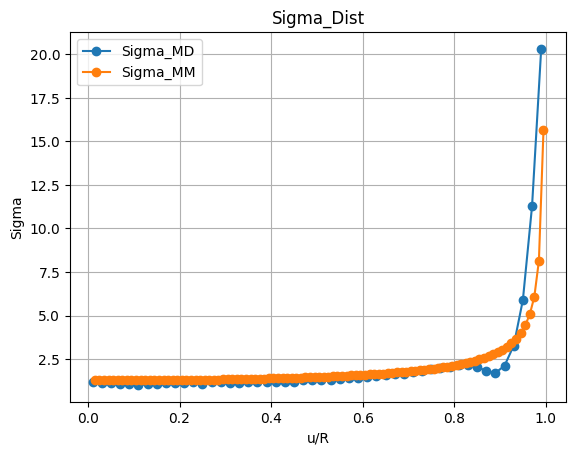

In [9]:
Robert_Data=pd.read_csv(r"c:\Users\ESTACION\Downloads\sigma.dat", sep='\t')

Density_Info['u/R'] = ((Density_Info['Fin']+Density_Info['Inicio'])/2)/r_1
Density_Info['Sigma'] = (Density_Info['Count'] * Q) / (np.pi * ((Density_Info['Fin']**2)-(Density_Info['Inicio']**2)))

area_y1 = np.trapz(Density_Info['Sigma'], Density_Info['u/R'])
area_y2 = np.trapz(Robert_Data["Sigma"], Robert_Data["u/R"])

Factor_Esc = area_y2 / area_y1

Density_Info['Sigma'] = Density_Info['Sigma'] * Factor_Esc

plt.plot(Density_Info["u/R"], Density_Info["Sigma"], label="Sigma_MD", marker='o', linestyle='-')
plt.plot(Robert_Data["u/R"], Robert_Data["Sigma"], label="Sigma_MM", marker='o', linestyle='-')
plt.xlabel("u/R")  # Etiqueta del eje x
plt.ylabel("Sigma")
plt.title("Sigma_Dist")
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig(os.path.join(output_dir, "Sigma_Dist_Comp.png"))

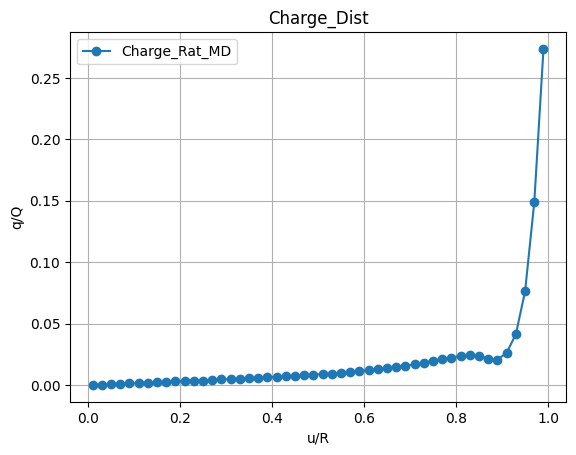

In [10]:
Robert_Data=pd.read_csv(r"c:\Users\ESTACION\Downloads\sigma.dat", sep='\t')

Density_Info['q/Q'] = Density_Info['Count'] / ((N/2)*len(System_DF))

plt.plot(Density_Info["u/R"], Density_Info["q/Q"], label="Charge_Rat_MD", marker='o', linestyle='-')
# plt.plot(Robert_Data["u/R"], Robert_Data["Sigma"], label="Sigma_MM", marker='o', linestyle='-')
plt.xlabel("u/R")  # Etiqueta del eje x
plt.ylabel("q/Q")
plt.title("Charge_Dist")
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig(os.path.join(output_dir, "Charge_Dist_Comp.png"))

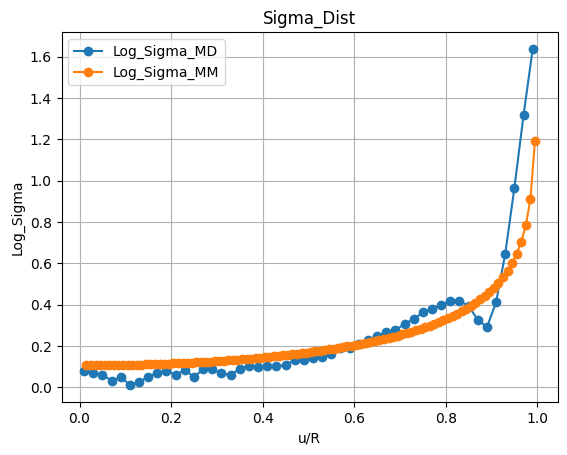

In [11]:
Density_Info["Log_Sigma"] = np.log10(Density_Info['Sigma'])
Robert_Data["Log_Sigma"] = np.log10(Robert_Data["Sigma"])

area_y1 = np.trapz(Density_Info['Log_Sigma'], Density_Info['u/R'])
area_y2 = np.trapz(Robert_Data["Log_Sigma"], Robert_Data["u/R"])

Factor_Esc = area_y2 / area_y1

Density_Info['Log_Sigma'] = Density_Info['Log_Sigma'] * Factor_Esc

plt.plot(Density_Info["u/R"], Density_Info["Log_Sigma"], label="Log_Sigma_MD", marker='o', linestyle='-')
plt.plot(Robert_Data["u/R"], Robert_Data["Log_Sigma"], label="Log_Sigma_MM", marker='o', linestyle='-')
# plt.semilogx(Density_Info["u/R"], Density_Info["Log_Sigma"], label='Log_Sigma_MD')
# plt.semilogx(Robert_Data["u/R"], Robert_Data["Log_Sigma"], label='Log_Sigma_MM')
plt.xlabel("u/R")  # Etiqueta del eje x
plt.ylabel("Log_Sigma")
plt.title("Sigma_Dist")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "Log_Sigma_Dist_Comp.png"))